In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler, RobustScaler

from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import optuna
from sklearn import set_config
from sklearn.linear_model import LassoCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.base import BaseEstimator, TransformerMixin

import random

import pdb

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Cargar el archivo df_train.parquet y df_test.parquet
train_dataset = pd.read_parquet('df_train.parquet').head(10000)

test_dataset  = pd.read_parquet('df_test.parquet').head(10000)

data_df = pd.read_parquet('df_train.parquet').head(10000)



## 1: Comprensión y Preparación de los Datos

Objetivo: Obtener un entendimiento claro de los datos y realizar un preprocesamiento exhaustivo.

### 1.1: Análisis Exploratorio de Datos (EDA)

#### 1.1.1: Revisión del Conjunto de Datos

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 16484 to 21600
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   MEDICAMENTOS                   10000 non-null  float64
 1   MEDICINA ESPECIALIZADA         10000 non-null  float64
 2   MEDICINA GENERAL               10000 non-null  float64
 3   Cant_gr_flia                   10000 non-null  int64  
 4   Cant_riesgos_flia_mean         10000 non-null  float64
 5   min_Tiempo_CP_Fliar            2 non-null      float64
 6   Cant_Fliar_CP                  10000 non-null  float64
 7   psa_max_gr_flia                74 non-null     float64
 8   psa_min_gr_flia                74 non-null     float64
 9   Cant_Fliar_riesgos             10000 non-null  float64
 10  cantidad_serv_flia             10000 non-null  float64
 11  Pendiente_flia                 10000 non-null  float64
 12  Intercepto_flia                10000 non-null  

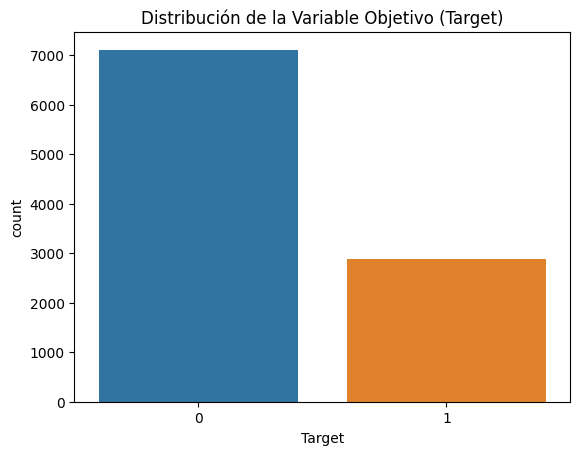

In [3]:


# Obtener información básica del dataset
print(data_df.info())  # Ver los tipos de datos y si hay valores nulos
print(data_df.describe())  # Estadísticas descriptivas de las variables numéricas
print(data_df.head())  # Primeras filas del dataset para familiarizarse con las columnas

# Visualizar la distribución de la variable objetivo "Target"
sns.countplot(x='Target', data=data_df)
plt.title('Distribución de la Variable Objetivo (Target)')
plt.show()

#### 1.1.2: Análisis del Baseline

Baseline ROC_AUC: 0.6551923021888395


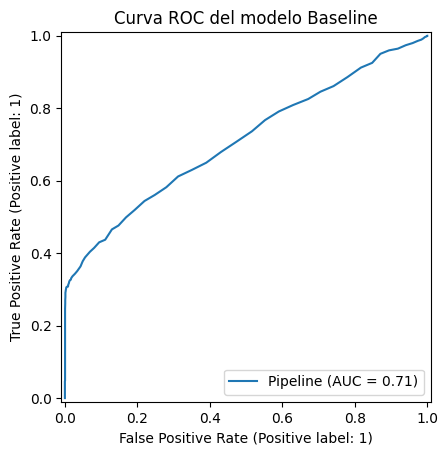

In [4]:
# Importar librerías necesarias
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

# Separar las variables predictoras y la variable objetivo
X = data_df.drop('Target', axis=1)  # Elimina la columna objetivo 'Target'
y = data_df['Target']  # Columna objetivo

# Identificar variables categóricas y numéricas
cat_features = X.select_dtypes(include=['object']).columns.tolist()  # Variables categóricas
num_features = X.select_dtypes(exclude=['object']).columns.tolist()  # Variables numéricas

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear un transformador para las variables numéricas y categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_features),  # Imputación en numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # OneHotEncoding en categóricas
    ])

# Crear un pipeline con el preprocesador y un modelo de Random Forest
baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Transformaciones en los datos
    ('model', RandomForestClassifier(random_state=42))  # Modelo Random Forest
])

# Entrenar el modelo con el pipeline
baseline_pipeline.fit(X_train, y_train)

# Predecir los resultados en el conjunto de prueba
y_pred = baseline_pipeline.predict(X_test)

# Evaluar el modelo con la métrica de ROC AUC
auc = roc_auc_score(y_test, y_pred)
print(f"Baseline ROC_AUC: {auc}")
# Graficar la curva ROC
RocCurveDisplay.from_estimator(baseline_pipeline, X_test, y_test)
plt.title('Curva ROC del modelo Baseline')
plt.show()

El modelo inicial que construimos tiene una capacidad del 78.19% para distinguir entre pacientes con niveles de PSA anormales y normales. Este es un buen punto de partida para nuestro análisis, ya que nos da una base sólida sobre la cual podemos trabajar. Aún así, sabemos que en el ámbito médico, donde la detección temprana es crítica, queremos reducir al mínimo el margen de error. Por eso, continuaremos optimizando el modelo para mejorar su precisión

### 1.2: Identificación de Problemas en los Datos

#### 1.2.1: Análisis de Valores Faltantes

Número de valores faltantes por columna:
min_Tiempo_CP_Fliar      9998
psa_max_gr_flia          9926
psa_min_gr_flia          9926
IMC                      4423
AGRUPACION_SISTOLICA     1401
AGRUPACION_DIASTOLICA    1401
RIESGOS                  6952
PERDIDA_DE_PESO          7589
CANCER_MAMA_FAMILIAR     2944
dtype: int64

Porcentaje de valores faltantes por columna:
min_Tiempo_CP_Fliar      99.98
psa_max_gr_flia          99.26
psa_min_gr_flia          99.26
IMC                      44.23
AGRUPACION_SISTOLICA     14.01
AGRUPACION_DIASTOLICA    14.01
RIESGOS                  69.52
PERDIDA_DE_PESO          75.89
CANCER_MAMA_FAMILIAR     29.44
dtype: float64


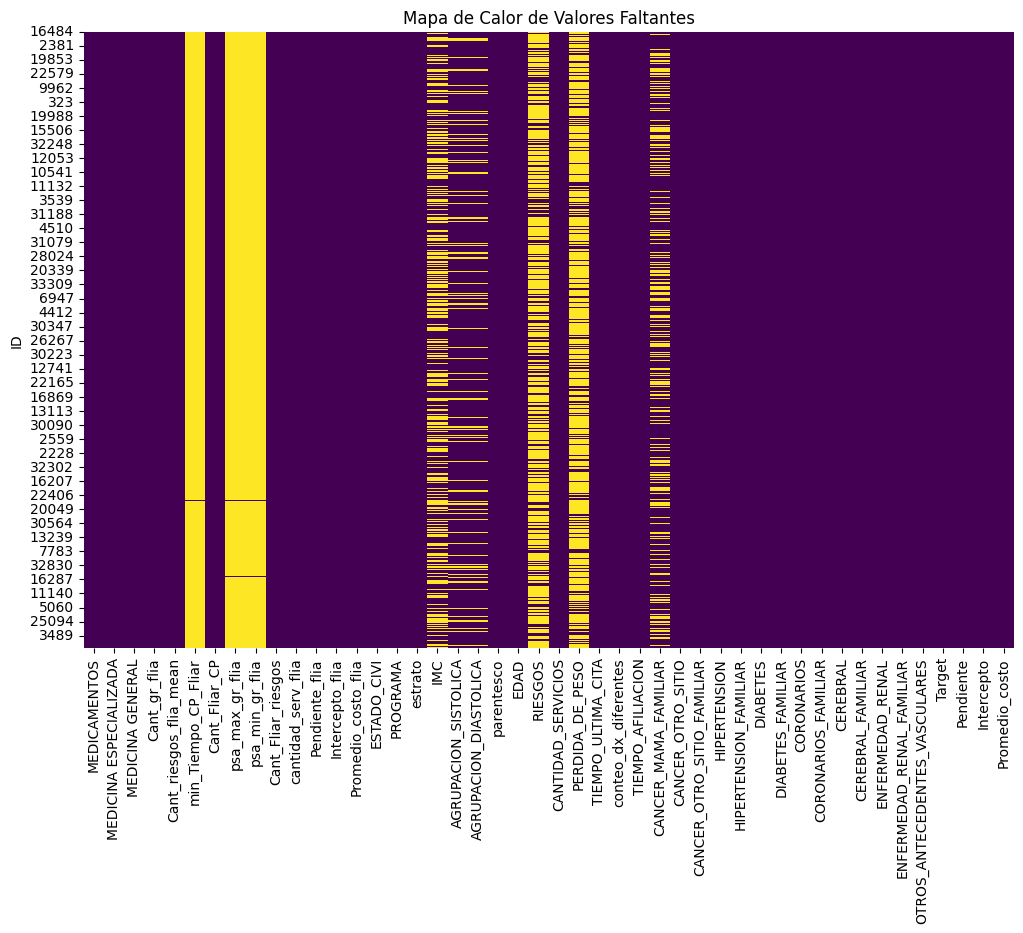

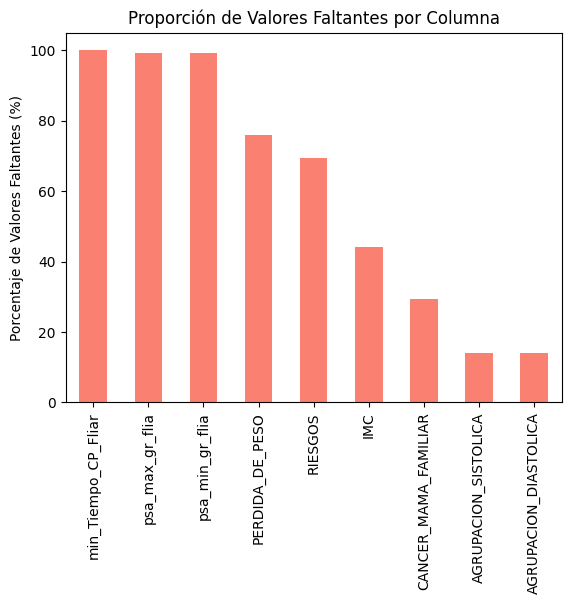

In [5]:
# Ver el número total de valores faltantes en cada columna
missing_values = data_df.isnull().sum()
print("Número de valores faltantes por columna:")
print(missing_values[missing_values > 0])  # Mostrar solo columnas con valores faltantes

# Mostrar la proporción de valores faltantes en porcentaje
missing_percentage = data_df.isnull().mean() * 100
print("\nPorcentaje de valores faltantes por columna:")
print(missing_percentage[missing_percentage > 0])  # Mostrar solo columnas con valores faltantes

# Visualización de valores faltantes con un heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data_df.isnull(), cbar=False, cmap='viridis')
plt.title('Mapa de Calor de Valores Faltantes')
plt.show()

# Visualización de la proporción de valores faltantes con un gráfico de barras
missing_percentage[missing_percentage > 0].sort_values(ascending=False).plot(kind='bar', color='salmon')
plt.title('Proporción de Valores Faltantes por Columna')
plt.ylabel('Porcentaje de Valores Faltantes (%)')
plt.show()

1. Variables con una Alta Proporción de Valores Faltantes
- Las variables min_Tiempo_CP_Fliar, psa_max_gr_flia, psa_min_gr_flia y psa_gr_flia tienen un porcentaje de valores faltantes que se acerca o alcanza el 100%. Esto indica que prácticamente toda la información en estas columnas está ausente.
- Conclusión: Es probable que estas columnas no proporcionen suficiente información útil debido al alto porcentaje de valores faltantes. Estas se pueden considerar para eliminar del análisis, ya que imputar un porcentaje tan alto de valores faltantes podría introducir sesgos o no ser útil.

2. Variables con Valores Faltantes Moderados
- Variables como PERDIDA_DE_PESO, RIESGOS y IMC tienen entre un 40% y 60% de valores faltantes.
- Conclusión: Estas variables tienen una cantidad significativa de datos faltantes, pero aún pueden contener información valiosa. En este caso, podría ser viable aplicar técnicas de imputación para completar estos valores y mantener la información.

3. Variables con Bajos Valores Faltantes
- AGRUPACION_SISTOLICA, AGRUPACION_DIASTOLICA, y CANCER_MAMA_FAMILIAR tienen menos del 20% de valores faltantes.
- Conclusión: Para estas columnas, la imputación sería una buena solución, ya que tienen una cantidad manejable de datos faltantes y se puede completar sin distorsionar demasiado la distribución.

#### 1.2.2: Análisis de Outliers

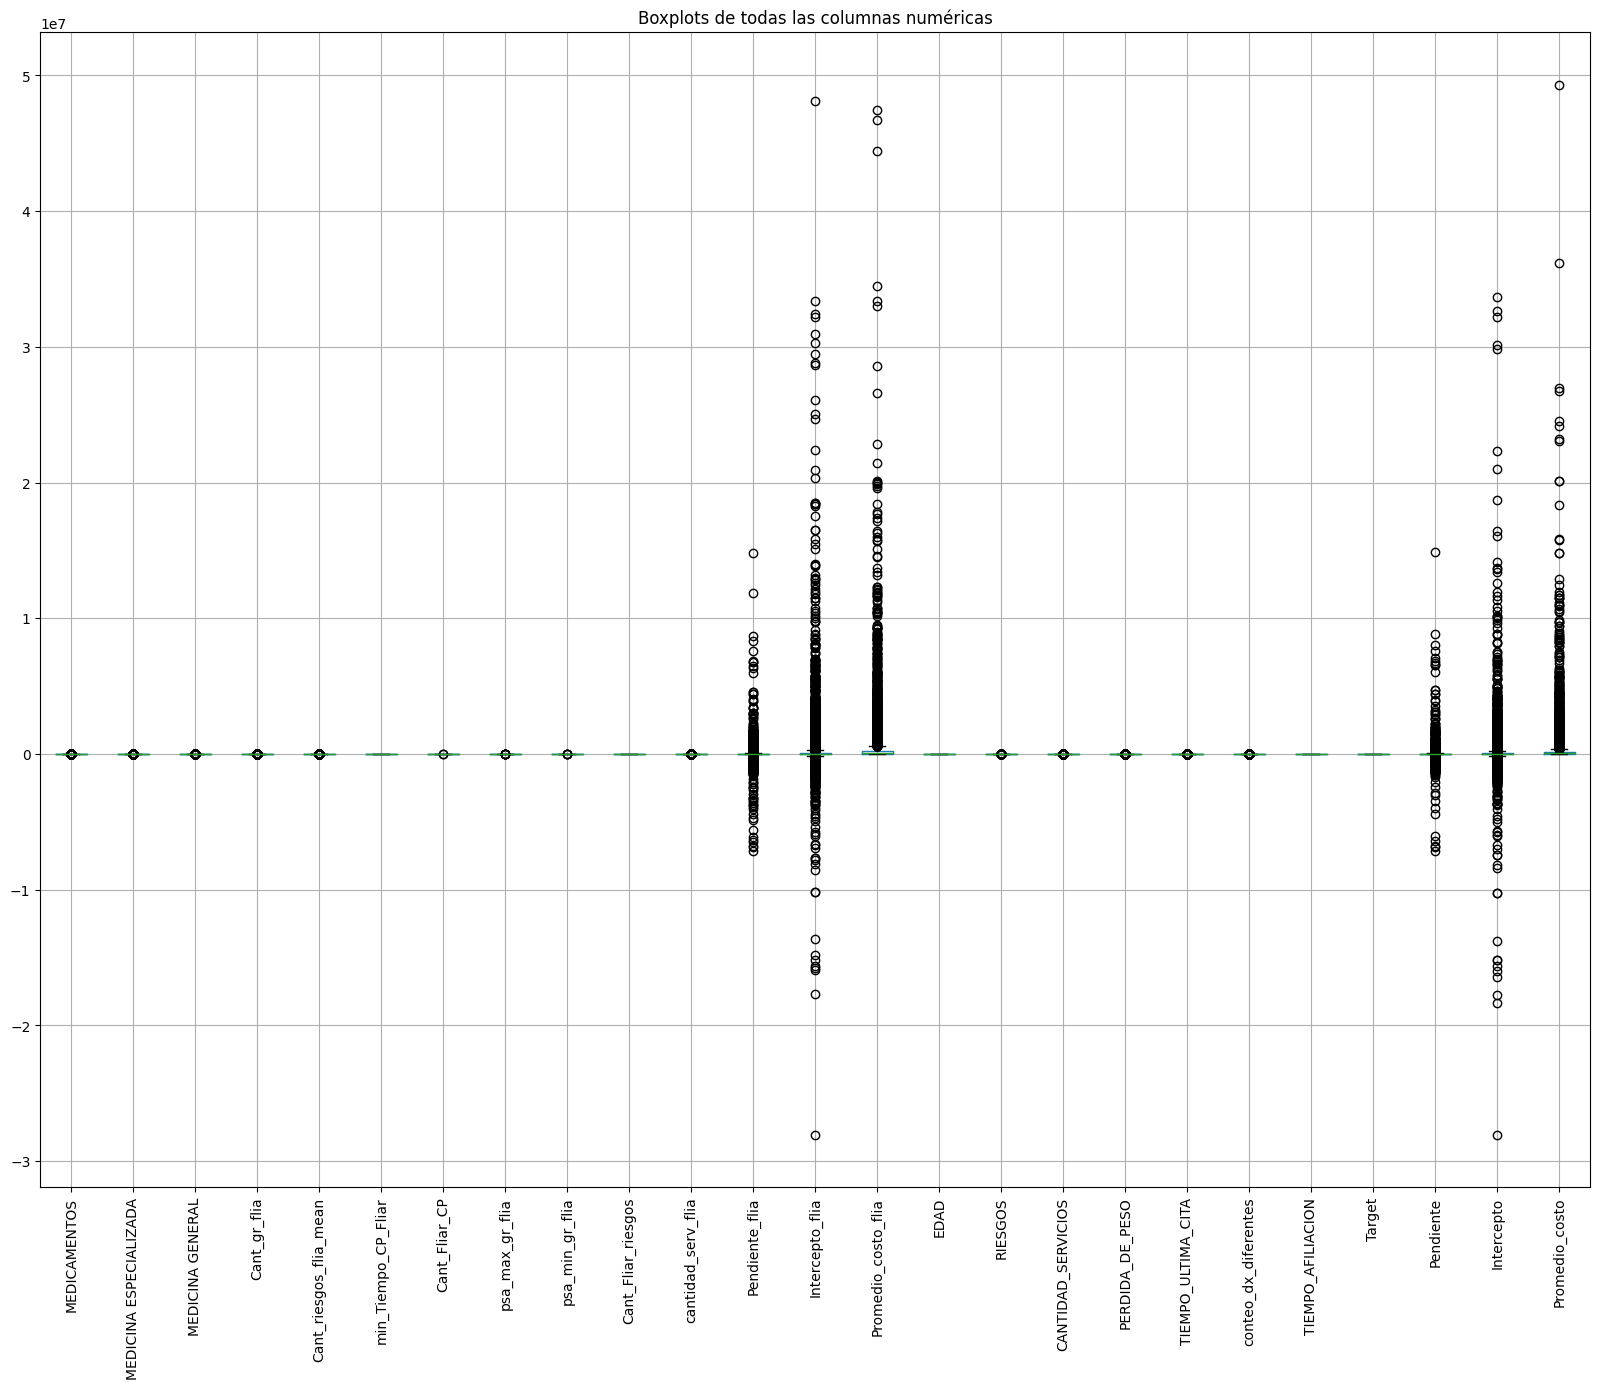

In [6]:
# Visualización de outliers usando boxplots para todas las columnas numéricas
plt.figure(figsize=(20, 15))
data_df.boxplot(rot=90)
plt.title('Boxplots de todas las columnas numéricas')
plt.show()

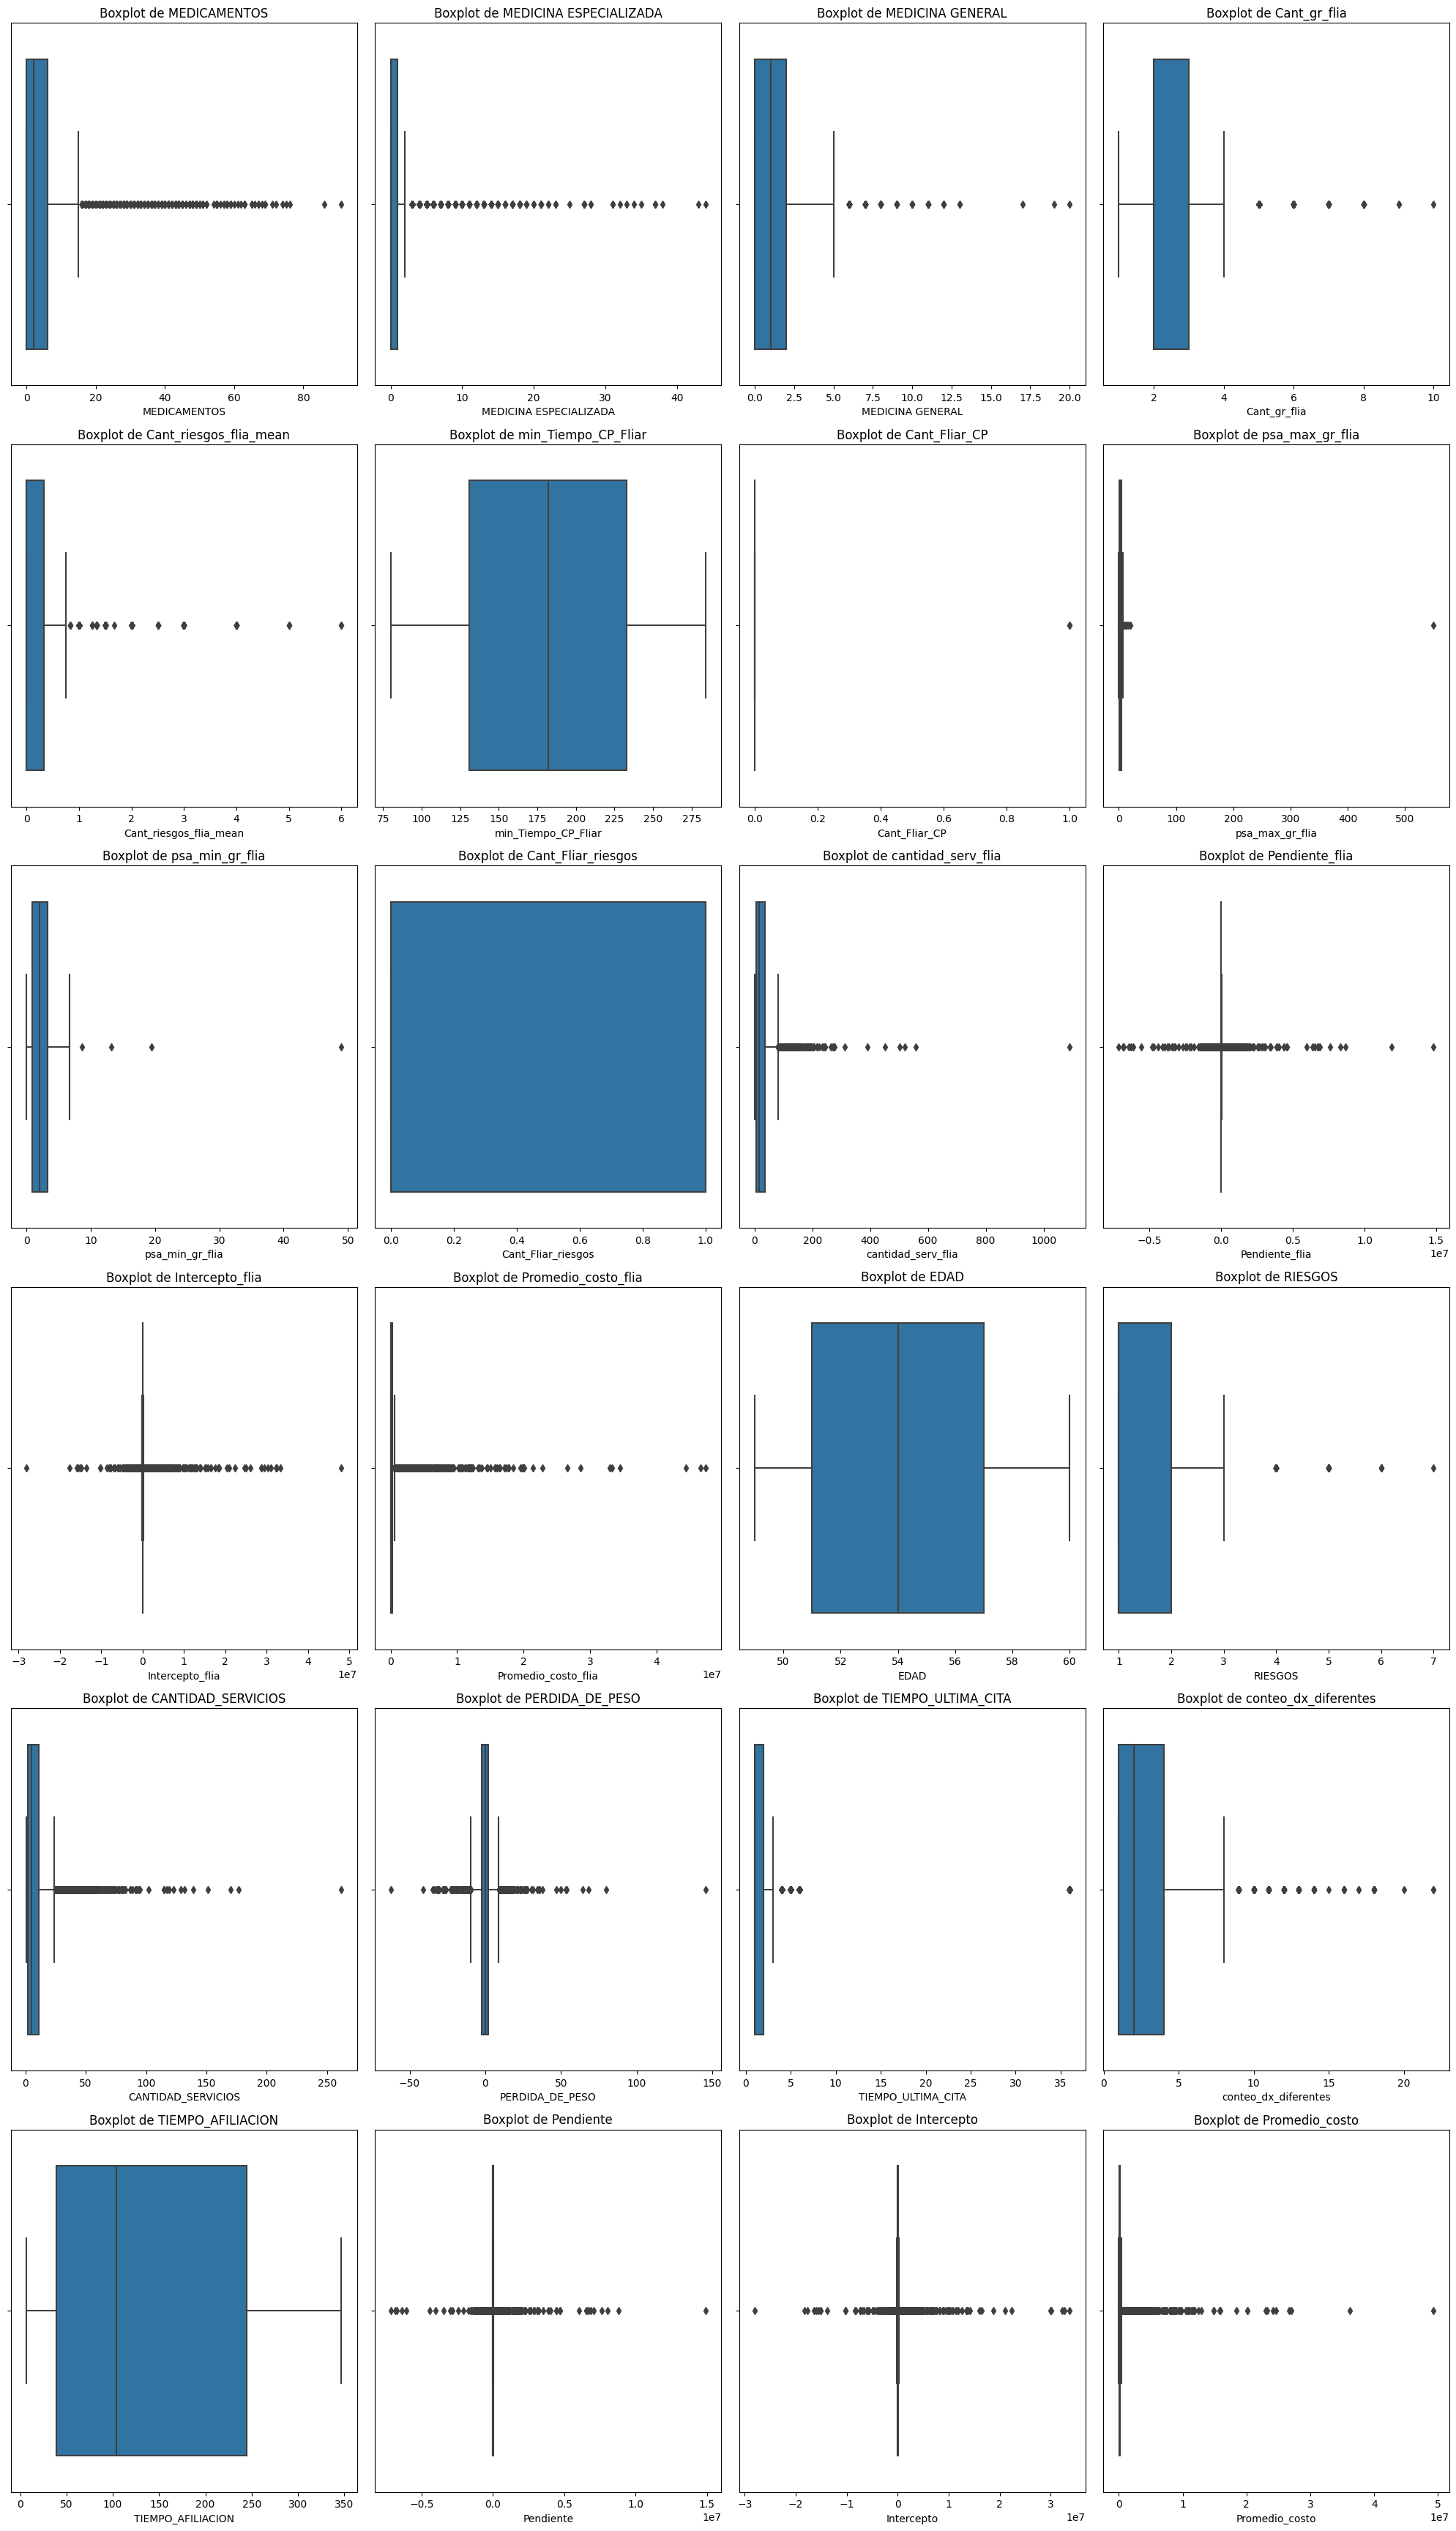

In [7]:
# Visualización de outliers usando boxplots por separado, para todas las columnas numéricas, dibujando 4 graficas por linea
num_columns = X.select_dtypes(include=[np.number]).columns.tolist()

plt.figure(figsize=(20, 40))
for i, col in enumerate(num_columns):
    plt.subplot(len(num_columns) // 4 + 1, 4, i + 1)
    sns.boxplot(x=X[col])
    plt.title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

Algunas variables muestran una gran cantidad de outliers, lo que podría indicar:

- 1.AGRUPACION_DIASTOLICA y AGRUPACION_SISTOLICA (Tensión Arterial):
Los valores atípicos en estas variables pueden representar mediciones de presión arterial anormalmente altas o bajas. Es probable que estos datos correspondan a pacientes con hipertensión o hipotensión no controlada.

- 2.Cant_Fliar_CP (Familiar con cáncer de próstata):
Dado que esta es una variable binaria o categórica (Sí/No), no debería presentar outliers, pero si el boxplot muestra valores extremos, podría ser por codificación incorrecta o errores en los datos.

- 3.Cant_gr_flia (Cantidad de personas en el grupo familiar):
Aquí los outliers pueden representar familias excepcionalmente grandes. Dependiendo del contexto del análisis, estos valores pueden ser importantes para identificar patrones relacionados con familias numerosas.

- 4.cantidad_serv_flia y CANTIDAD_SERVICIOS (Cantidad de servicios prestados):
Las observaciones atípicas en estas variables podrían reflejar familias o individuos que han utilizado un número significativamente mayor de servicios médicos en el último semestre.

- 5.conteo_dx_diferentes (Número de diagnósticos en el último semestre):
Los valores extremos aquí podrían estar asociados a pacientes con múltiples enfermedades crónicas o comorbilidades.

- 6.EDAD:
En esta variable, los valores atípicos probablemente se encuentren en los extremos del espectro, es decir, individuos muy jóvenes o muy mayores. Estos grupos podrían requerir un enfoque diferente en cuanto a tratamientos y prevención de enfermedades.

- 7.IMC (Índice de Masa Corporal):
Los valores extremadamente altos o bajos de IMC pueden indicar obesidad severa o desnutrición. Estos casos son críticos en el análisis de salud, ya que pueden estar asociados a otras condiciones como diabetes o enfermedades cardiovasculares.

- 8.Pendiente, Pendiente_flia, Intercepto, Intercepto_flia (Costos familiares y personales):
Estas variables muestran outliers que probablemente representan individuos o familias con costos de salud extremadamente altos. Estos podrían estar relacionados con enfermedades crónicas, tratamientos costosos o hospitalizaciones prolongadas.

- 9.Promedio_costo, Promedio_costo_flia:
Al igual que las variables anteriores de costos, los outliers en estas variables probablemente representan promedios excepcionalmente altos en los costos de atención médica de individuos o familias.

- 10.psa_max_gr_flia, psa_min_gr_flia (Resultados de PSA - Cáncer de Próstata):
Los outliers en estos datos pueden corresponder a resultados de PSA anormalmente altos o bajos en familiares de los usuarios, lo que podría indicar un riesgo elevado de cáncer de próstata.

- 11.PERDIDA_DE_PESO (Variación de peso en el último año):
Outliers: Valores atípicos en esta variable pueden reflejar cambios de peso significativos, lo que podría estar asociado a problemas de salud como desnutrición, caquexia (pérdida extrema de peso por enfermedades crónicas) o recuperación postoperatoria.

- 12.TIEMPO_AFILIACION y TIEMPO_ULTIMA_CITA:
Los valores extremos en estas variables pueden representar usuarios que han estado afiliados por mucho tiempo o que no han tenido una cita en mucho tiempo. Podrían ser indicadores de poca adherencia a los servicios de salud o de usuarios fieles al sistema.

### 1.3: Imputación de Valores Faltantes y Transformaciones

In [8]:
# Separar el conjunto de datos en características (X) y la variable objetivo (y)
X = data_df.drop('Target', axis=1)
y = data_df['Target']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### 1.3.1: Imputación de Valores Faltantes

In [9]:
numerical = data_df.select_dtypes(include=np.number).columns.tolist()
numerical.remove('Target')

categorical = data_df.select_dtypes(exclude=np.number).columns.tolist()

categorical.remove('estrato')
ordinal = ['estrato']

In [10]:
ordinal

['estrato']

### 1.4: Transformaciones Adicionales con Pipelines

In [11]:

# Pipeline datos ordinales
ordinal_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder())
]),


#### 1.4.1: Normalización y Escalado

In [12]:
# Pipeline datos numéricos
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

#### 1.4.2: Dummificación de Variables Categóricas

In [13]:
# Pipeline datos categoricos
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse_output=True, handle_unknown="ignore"))
])

# Pegado de los tres pipelines
preprocessing_pipeline = ColumnTransformer([
    ("categorical_preprocessor", categorical_pipeline, categorical),
    ("ordinal_preprocessor", ordinal_pipeline, ordinal),
    ("numerical_preprocessor", numerical_pipeline, numerical)
])

## 2: Feature Engineering y Optimización del Flujo de Trabajo

### 2.1: Transformaciones de Datos en el Pipeline

#### 2.2.1: Tratamiento de Variables Categóricas

#### 2.2.2: Reducción de Dimensionalidad

Aunque tanto PCA (Análisis de Componentes Principales) como LDA (Análisis Discriminante Lineal)  son técnicas de reducción de dimensionalidad, sus objetivos y aplicaciones son diferentes:

- PCA es no supervisado: Solo busca la proyección que maximiza la varianza general en los datos, sin tener en cuenta las clases.

- LDA es supervisado: Usa la información de las etiquetas de clase para encontrar la proyección que maximiza la separación entre clases.

Por lo tanto trabajaremos con LDA

#### 2.2.3: Selección de Variables Relevantes

### 2.2: Construcción de Pipelines Complejos para el Modelado

#### 2.2.1: Construcción de un Pipeline Completo

In [14]:
class DropHighMissing(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.75):
        self.threshold = threshold
        self.columns_to_drop = []

    def fit(self, X, y=None):
        # Calcular el porcentaje de valores faltantes por columna
        missing_percent = X.isnull().mean()
        # Seleccionar las columnas que tienen más del umbral de valores faltantes
        self.columns_to_drop = missing_percent[missing_percent > self.threshold].index
        return self

    def transform(self, X):
        # Eliminar las columnas con más del 75% de valores faltantes
        return X.drop(columns=self.columns_to_drop)

In [15]:
class ModelOptimization:
  def __init__(self, df):
    self.df = df.copy()# .head(100)
    self.df = pd.DataFrame(self.df)
    
    # BEGIN: Remove columns with more than 75% missing values
    missing_threshold = 0.75
    self.df = self.df.loc[:, self.df.isnull().mean() < missing_threshold]
    # END:
    
    self.num_features = self.df.select_dtypes(exclude=['object']).columns.tolist()  # Variables numéricas
    self.ord_features = ['estrato']
    self.cat_features = self.df.select_dtypes(include=['object']).columns.tolist()  # Variables categóricas
    self.cat_features.remove('estrato'
                             )
    # Separar el conjunto de datos en características (X) y la variable objetivo (y)
    self.X = self.df.drop('Target', axis=1)
    self.y = self.df['Target']

    # Dividir los datos en conjuntos de entrenamiento y prueba
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=42)
   
    # Eliminar la columna 'Target' de las variables numéricas si está presente
    if 'Target' in self.num_features:
            self.num_features.remove('Target')
        
## Ejecutar modelo SVC (Support Vector Classifier)      
  def run_svc(self,num_strategy, scaler_type, 
              ord_strategy, ord_handle_unk, 
              cat_strategy, sparse_output, cat_handle_unk,
              C, kernel, gamma):
    
    # Datos Numericos
    if scaler_type == "StandardScaler":
        num_scaler = StandardScaler()
    elif scaler_type == "MinMaxScaler":
        num_scaler = MinMaxScaler()
    elif scaler_type == "RobustScaler":
        num_scaler = RobustScaler()
          
    if num_strategy == "constant":
        num_fval = -1
        num_imputer = SimpleImputer(strategy=num_strategy, fill_value=num_fval)
    else:
        num_fval = None
        num_imputer = SimpleImputer(strategy=num_strategy)   
        
    # Pipeline datos numéricos
    numerical_pipeline = Pipeline(steps=[
        ("imputer", num_imputer),
        ("scaler",  num_scaler)
    ])
    
    # Pipeline datos ordinales
    if ord_strategy == "constant":
        ord_fval = -1 #trial.suggest_int("fill_value", -1000, 1000)
        ord_imputer = SimpleImputer(strategy=ord_strategy, fill_value=ord_fval)
    else:
        ord_fval = None
        ord_imputer = SimpleImputer(strategy=ord_strategy)   

    # Si se selecciona 'use_encoded_value', sugerir un valor para las categorías desconocidas
    if ord_handle_unk == "use_encoded_value":
        unknown_value = -1 #trial.suggest_int("unknown_value", -1000, 1000)
    else:
        unknown_value = None

    ord_encoder = OrdinalEncoder(handle_unknown=ord_handle_unk, unknown_value=unknown_value)

    ordinal_pipeline = Pipeline(steps=[
        ("imputer", ord_imputer),
        ("encoder", ord_encoder)
    ])
    
    
#####################################################################################
    # Datos No-Numericos

    # Si se selecciona 'constant', sugerir el valor para imputar
    if cat_strategy == "constant":
        cat_fval = -1 #trial.suggest_int("fill_value", -1000, 1000)
        cat_imputer = SimpleImputer(strategy=cat_strategy, fill_value=cat_fval)
    else:
        cat_fval = None
        cat_imputer = SimpleImputer(strategy=cat_strategy)
    
    # Seleccionar si el OneHotEncoder debe devolver una matriz dispersa o densa
    cat_encoder = OneHotEncoder(sparse_output=sparse_output, handle_unknown=cat_handle_unk)

    categorical_pipeline = Pipeline(steps=[
        ("imputer", cat_imputer),
        ("encoder", cat_encoder)
    ])

# Pegado de los tres pipelines
    preprocessing_pipeline = ColumnTransformer(transformers=[
        ("numerical_preprocessor", numerical_pipeline, self.num_features),
        ("ordinal_preprocessor", ordinal_pipeline, self.ord_features),
        ("categorical_preprocessor", categorical_pipeline, self.cat_features)
    ])
   
    if kernel in ["rbf", "poly", "sigmoid"]:
        lv_gamma = gamma
    else:
        lv_gamma = "scale"  # Si es lineal, gamma no aplica

    # Selección de características con Lasso
    feature_selector = SelectFromModel(LassoCV(cv=5, random_state=42))
   
    model = Pipeline(steps=[
        ("drop_high_missing", DropHighMissing(threshold=0.75)),  # Remover columnas con más del 75% de valores faltantes
        ("preprocessor", preprocessing_pipeline),
        # 1. Selección de características con SelectKBest (ANOVA F-test)
        ("feature_selection", SelectKBest(score_func=f_classif, k=10)),  # Selecciona las 10 mejores características        
        # 2. Reducción de dimensionalidad con PCA
        ("pca", PCA(n_components=3)),  # Reducir a 2 componentes principales
#       ("classifier", SVC(C=C, kernel=kernel, gamma=lv_gamma, probability=True, random_state=42))
    ])
    X_trans = model.fit_transform(self.X_train, self.y_train)

    # Crear el modelo SVC
    svc_model = SVC(probability=True, random_state=42)  # 'probability=True' es necesario para obtener probabilidades

    # Entrenar el modelo con los datos de entrenamiento
    svc_model.fit(X_trans, self.y_train)

    X_ts = model.transform(self.X_test)

    # Obtener las probabilidades para el conjunto de prueba
    y_prob = svc_model.predict_proba(X_ts)[:, 1]  # Probabilidades para la clase positiva (1)

    # Calcular el ROC AUC
    roc_auc = roc_auc_score(y_test, y_prob)
#   model.fit(self.X_train, self.y_train)
    # Predecir probabilidades para calcular ROC AUC
#   y_pred_proba = model.predict_proba(self.X_test)[:, 1]
#   roc_auc      = roc_auc_score(self.y_test, y_pred_proba)
    return roc_auc #, model



#   model
    # Predecir probabilidades para calcular ROC AUC
#   y_pred_proba = model.predict_proba(self.X_test)[:, 1]

#   Calcular el ROC AUC
#   roc_auc = roc_auc_score(self.y_test, y_pred_proba)
    # Evaluar el modelo utilizando Cross Validation
    #scores = cross_val_score(model, self.X_train, self.y_train, cv=3, scoring="roc_auc")
   
    # Devolver la media de la precisión como objetivo a maximizar
#   return scores.mean() #roc_auc #
#   media = np.random.rand()
#   print(model)
#   return media
###################################################################################
  def objective_svc(self, trial):
    num_strategy    = trial.suggest_categorical('num_strategy', ['median']) #,'mean', 'most_frequent', 'constant'])
    scaler_type     = trial.suggest_categorical('scaler', ['StandardScaler']) #, 'MinMaxScaler', 'RobustScaler'])
####    
    ord_strategy    = trial.suggest_categorical('ord_strategy', ['most_frequent'])#, 'constant'])
    ord_handle_unk  = trial.suggest_categorical('ord_handle_unknown', ['use_encoded_value']) #,'error'])
####
    cat_strategy    = trial.suggest_categorical('cat_strategy', ['most_frequent'])#, 'constant'])
    sparse_output   = trial.suggest_categorical("sparse_output", [True])#, False])
    cat_handle_unk  = trial.suggest_categorical('cat_handle_unknown', ["ignore"])#, "error"])

### Hiperparámetros del modelo SVC
    C               = trial.suggest_float("svc_C", 0.1, 10.0)
    kernel          = trial.suggest_categorical("svc_kernel", ["linear"]) #, "rbf", "poly", "sigmoid"])
    gamma           = trial.suggest_float("svc_gamma", 0.001, 1.0)

    model = self.run_svc(num_strategy=num_strategy, scaler_type=scaler_type,
                         ord_strategy=ord_strategy, ord_handle_unk=ord_handle_unk,
                         cat_strategy=cat_strategy, sparse_output=sparse_output,cat_handle_unk=cat_handle_unk,
                         C=C, kernel=kernel, gamma=gamma) 
    
    return model

In [16]:
X = 1/0

ZeroDivisionError: division by zero

In [17]:

trials        = 10
model_optimization = ModelOptimization(data_df)
results = []
study_svc = optuna.create_study(direction='maximize')
study_svc.optimize(model_optimization.objective_svc, n_trials=trials)

results.append({
'tipo': 'SVC',
'Score.Mean': study_svc.best_value,
'best_params': study_svc.best_params })

[I 2024-09-30 20:56:15,660] A new study created in memory with name: no-name-a18e844b-73da-4154-b1de-f26109910237
[I 2024-09-30 20:56:37,199] Trial 0 finished with value: 0.5734696505737915 and parameters: {'num_strategy': 'median', 'scaler': 'StandardScaler', 'ord_strategy': 'most_frequent', 'ord_handle_unknown': 'use_encoded_value', 'cat_strategy': 'most_frequent', 'sparse_output': True, 'cat_handle_unknown': 'ignore', 'svc_C': 9.76638991095358, 'svc_kernel': 'linear', 'svc_gamma': 0.5439140584973843}. Best is trial 0 with value: 0.5734696505737915.
[I 2024-09-30 20:56:58,693] Trial 1 finished with value: 0.5734696505737915 and parameters: {'num_strategy': 'median', 'scaler': 'StandardScaler', 'ord_strategy': 'most_frequent', 'ord_handle_unknown': 'use_encoded_value', 'cat_strategy': 'most_frequent', 'sparse_output': True, 'cat_handle_unknown': 'ignore', 'svc_C': 6.433245828457545, 'svc_kernel': 'linear', 'svc_gamma': 0.0763372226005988}. Best is trial 0 with value: 0.573469650573791